In [1]:
import os
import cv2
import subprocess
import shutil
from tqdm import tqdm
import pycolmap
from pycolmap import logging
from pathlib import Path
import numpy as np
import pandas as pd
import pycolmap
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy.spatial.distance import cdist

In [2]:
PROJECT_DIR = "flowers_example"
SFM_PATH = f"../{PROJECT_DIR}"
CUDA = False
OBJECTIVE_POINTS = ([0.1, 0.2, 0.6], [0, -0.4, 1.2])

# 1. Split the video into frames

In [3]:
def split_video_into_frames():
    output_folder = os.path.join(f"{SFM_PATH}/images")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(f"{SFM_PATH}/video.mp4")
    
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        
        frame_count += 1
    
    cap.release()

split_video_into_frames()

# 2. SfM

In [4]:
def start_sfm_cuda():
    commands = [f".\COLMAP.bat automatic_reconstructor --image_path {PROJECT_DIR}/images --workspace_path {PROJECT_DIR}",
                f".\COLMAP.bat model_converter --input_path {PROJECT_DIR}/sparse/0 --output_path {PROJECT_DIR} --output_type TXT"]

    for command in commands:
        try:
            process = subprocess.Popen(command, cwd="..", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout, stderr = process.communicate()

            if process.returncode == 0:
                print("Command executed successfully:")
                print(stdout.decode())
            else:
                print("Error occurred during command execution:")
                print(stderr.decode())
        except Exception as e:
            print("Error:", str(e))


def incremental_mapping_with_tqdm(database_path, image_path, sfm_path):
    num_images = pycolmap.Database(database_path).num_images
    with tqdm(total=num_images, desc="Images registered:") as pbar:
        pbar.update(0)
        reconstructions = pycolmap.incremental_mapping(
            database_path,
            image_path,
            sfm_path,
            initial_image_pair_callback=lambda: pbar.update(2),
            next_image_callback=lambda: pbar.update(1),
        )
    return reconstructions

def start_sfm():
    output_path = Path(f"{SFM_PATH}/")
    image_path = output_path / "images"
    database_path = output_path / "database.db"
    sfm_path = output_path / "sparse"

    output_path.mkdir(exist_ok=True)
    logging.set_log_destination(logging.INFO, output_path / "INFO.log.")

    if database_path.exists():
        database_path.unlink()
    pycolmap.extract_features(database_path, image_path)
    pycolmap.match_exhaustive(database_path)

    if sfm_path.exists():
        shutil.rmtree(sfm_path)
    sfm_path.mkdir(exist_ok=True)

    recs = incremental_mapping_with_tqdm(database_path, image_path, sfm_path)
    for idx, rec in recs.items():
        logging.info(f"#{idx} {rec.summary()}")

    
def export_model():
    reconstruction = pycolmap.Reconstruction(Path(f"{SFM_PATH}/") / "sparse/0")
    reconstruction.write_text(Path(f"{SFM_PATH}/"))

    
    
if CUDA:
    start_sfm_cuda()
else:
    start_sfm()
    export_model()

Images registered:: 100%|██████████| 150/150 [07:01<00:00,  2.81s/it]


# 3. Load the image data and calculate camera poses

In [5]:
with open(os.path.join(SFM_PATH, 'images.txt'), 'r') as file:
    lines = file.readlines()

data = {
    'IMAGE_ID': [],
    'QW': [],
    'QX': [],
    'QY': [],
    'QZ': [],
    'TX': [],
    'TY': [],
    'TZ': [],
    'CAMERA_ID': [],
    'NAME': []
}

for line in lines:
    if "jpg" in line:
        line_data = line.strip().split(' ')
        image_id, qw, qx, qy, qz, tx, ty, tz, camera_id, name = line_data
        data['IMAGE_ID'].append(image_id)
        data['QW'].append(qw)
        data['QX'].append(qx)
        data['QY'].append(qy)
        data['QZ'].append(qz)
        data['TX'].append(tx)
        data['TY'].append(ty)
        data['TZ'].append(tz)
        data['CAMERA_ID'].append(camera_id)
        data['NAME'].append(name)

df = pd.DataFrame(data)

df.head()

,IMAGE_ID,QW,QX,QY,QZ,TX,TY,TZ,CAMERA_ID,NAME
0,1,0.99828853988933364,0.0095300620242498475,-0.055982178809047552,-0.013970135977435223,3.9973997578784783,-1.1501549089673584,1.3301701994502009,5,frame_0004.jpg
1,2,0.99829996853684289,0.0093820332027962274,-0.05587861136584004,-0.013664957524477753,4.0018004691995888,-1.1421890417147116,1.3259110506520444,6,frame_0005.jpg
2,3,0.99831025325504708,0.0089110157924316719,-0.055832064525416322,-0.013416877961014135,4.0056170663292452,-1.1378233563279465,1.3260510771480658,8,frame_0007.jpg
3,4,0.99830578756806709,0.0091520779653972151,-0.055832896036552004,-0.013582403954685816,4.0034178643232945,-1.1391724005869988,1.316700520674766,7,frame_0006.jpg
4,5,0.99829254502709575,0.0095005347161203537,-0.055906413876823005,-0.014007400574877437,3.9874573108307056,-1.1616413984103611,1.3144193192396245,4,frame_0003.jpg


In [6]:
def quaternion_to_rotation_matrix(qw, qx, qy, qz):
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
    ])

    return R

def add_camera_position_column(df):
    # camera position = -R^t * T
    rotation_matrices = np.array([quaternion_to_rotation_matrix(float(row['QW']), float(row['QX']), float(row['QY']), float(row['QZ'])) for _, row in df.iterrows()])
    inverse_rotation_matrices = np.transpose(rotation_matrices, axes=(0, 2, 1))
    translation_vectors = df[['TX', 'TY', 'TZ']].astype(float).values
    camera_positions = np.matmul(inverse_rotation_matrices, translation_vectors.reshape(-1, 3, 1)).squeeze()
    df['CAMERA_POSITION'] = [position.tolist() for position in camera_positions]


add_camera_position_column(df)

df.head()

,IMAGE_ID,QW,QX,QY,QZ,TX,TY,TZ,CAMERA_ID,NAME,CAMERA_POSITION
0,1,0.99828853988933364,0.0095300620242498475,-0.055982178809047552,-0.013970135977435223,3.9973997578784783,-1.1501549089673584,1.3301701994502009,5,frame_0004.jpg,"[4.152414181102329, -1.0148746858539186, 0.893..."
1,2,0.99829996853684289,0.0093820332027962274,-0.05587861136584004,-0.013664957524477753,4.0018004691995888,-1.1421890417147116,1.3259110506520444,6,frame_0005.jpg,"[4.155264057632389, -1.0097123295716888, 0.889..."
2,3,0.99831025325504708,0.0089110157924316719,-0.055832064525416322,-0.013416877961014135,4.0056170663292452,-1.1378233563279465,1.3260510771480658,8,frame_0007.jpg,"[4.158319885670436, -1.0083349772330208, 0.888..."
3,4,0.99830578756806709,0.0091520779653972151,-0.055832896036552004,-0.013582403954685816,4.0034178643232945,-1.1391724005869988,1.316700520674766,7,frame_0006.jpg,"[4.155492073370656, -1.008027527614769, 0.8800..."
4,5,0.99829254502709575,0.0095005347161203537,-0.055906413876823005,-0.014007400574877437,3.9874573108307056,-1.1616413984103611,1.3144193192396245,4,frame_0003.jpg,"[4.141056497924766, -1.0267031874668056, 0.880..."


# 4. Visualize cameras

In [7]:
fig = go.Figure(data=[go.Scatter3d(
    x=df['CAMERA_POSITION'].apply(lambda pos: pos[0]),
    y=df['CAMERA_POSITION'].apply(lambda pos: pos[1]),
    z=df['CAMERA_POSITION'].apply(lambda pos: pos[2]),
    mode='markers',
    marker=dict(
        size=5,
        color='red',
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    )
)

fig.update_layout(title_text='Camera Positions in 3D Space')

fig.show()

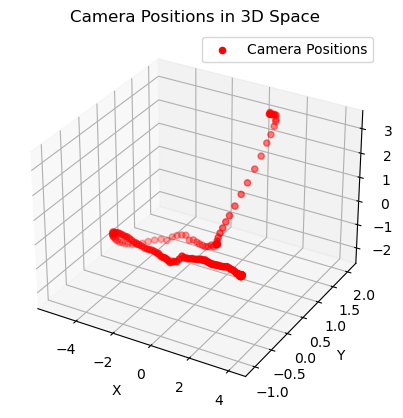

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df['CAMERA_POSITION'].apply(lambda pos: pos[0])
y = df['CAMERA_POSITION'].apply(lambda pos: pos[1])
z = df['CAMERA_POSITION'].apply(lambda pos: pos[2])

ax.scatter(x, y, z, c='r', marker='o', label='Camera Positions')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Camera Positions in 3D Space')

plt.legend()
plt.show()

# 5. Find nearest cameras/images to given points

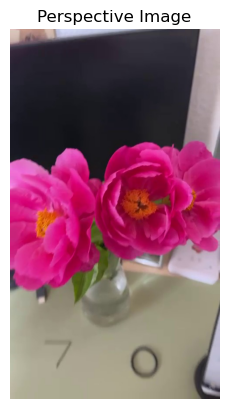

(IMAGE_ID                                                         126
QW                                               0.99716548294671825
QX                                              0.037047989636266751
QY                                               0.04555565991448636
QZ                                              0.047043893687756008
TX                                                0.6884658491306801
TY                                               0.57742985212663411
TZ                                               0.28455721075161211
CAMERA_ID                                                        129
NAME                                                  frame_0128.jpg
CAMERA_POSITION    [0.7138241664229301, 0.5332646431131329, 0.307...
Name: 125, dtype: object, array([0.7572889]))


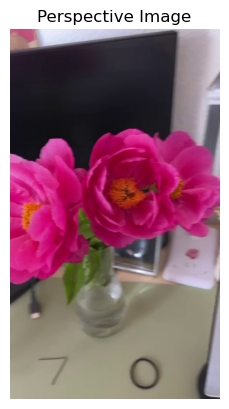

(IMAGE_ID                                                          49
QW                                               0.99910875751506045
QX                                           -0.00075719195999467148
QY                                              0.037090686691706454
QZ                                              0.020134504657070344
TX                                               0.48363350284498413
TY                                              -0.59055894141681442
TZ                                               0.21453503607407975
CAMERA_ID                                                         51
NAME                                                  frame_0050.jpg
CAMERA_POSITION    [0.44227696817873824, -0.6095688594474151, 0.2...
Name: 48, dtype: object, array([1.07043651]))


In [9]:
def find_nearest_camera(df, point):
    distances = cdist(df['CAMERA_POSITION'].tolist(), [point])
    nearest_index = distances.argmin()
    return (df.iloc[nearest_index], distances[nearest_index])

def get_nearest_images(df, show=True):
    for point in OBJECTIVE_POINTS:
        nearest_camera = find_nearest_camera(df, point)

        if show:
            perspective_image_name = nearest_camera[0].NAME
            perspective_image = plt.imread(f"{SFM_PATH}/images/{perspective_image_name}")
            plt.imshow(perspective_image)
            plt.axis('off')
            plt.title('Perspective Image')
            plt.show()
        print(nearest_camera)

get_nearest_images(df)